In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os
os.chdir('C:\\code\\activ')

In [3]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

tf.config.run_functions_eagerly(True)

In [4]:
ACTION_NUM = 5

In [5]:
model_list = []
for i in range(ACTION_NUM):
    model_list.append(tf.keras.models.load_model('./model/action_net{0}/'.format(i)))

In [6]:
dnn_model = tf.keras.models.load_model('./model/dnn.h5')

In [7]:
def shift_data(origin, d):
    shift_d = np.concatenate((origin[0][1::], d), axis=0).reshape(1, 12, 21)
    return shift_d

In [8]:
df = pd.read_excel('./documents/nov_nine_var.xlsx').iloc[:,1::].to_numpy()

scaler = MinMaxScaler()
scale_df = scaler.fit_transform(df)

data = scale_df[:,0:21][-1-12:-1].reshape(1, 12, 21)

In [9]:
goal_df = scaler.transform(pd.read_excel('./documents/result/basic_formula.xlsx').iloc[:,1::].to_numpy())
goal = goal_df[:,0:21][1].reshape(1, 21)

In [59]:
class Node:
    def __init__(self, parent, state):
        self.parent = parent
        self.child = None
        self.state = state

In [108]:
class Tree:
    def __init__(self, leaf_num, grow_type):
        self.root = None
        self.state_list = []
        self.type = grow_type
        self.leaf_num = leaf_num
        self.size = 0
        self.depth = 1

    def _size(self):
        i = 0
        t = self.size
        while True:
            t -=  self.leaf_num**i
            i += 1

            if t == 0:
                break

        self.depth = i

    @tf.function
    def average_the_state(self, node, child_state):
        state = tf.Variable(tf.zeros((5, 1, 21)))
        for i in range(5):
            state = state[i].assign(child_state[i][0][-1].reshape(1, 21))

        mean_state = tf.reduce_mean(state, 0)
        return mean_state

    @tf.function
    def sort_by_value(self, node, child_state):
        value = tf.Variable(tf.zeros(5))
        for i in range(5):
            state = child_state[i][0][-1].reshape(1, 21)
            value = value[i].assign(dnn_model(state)[0][0])

        argsort_order = tf.argsort(value)
        return argsort_order

    def pruning(self, leaf_node):
        if leaf_node.parent == None:
            return
            
        if leaf_node.parent.parent == None:
            return

        node = leaf_node.parent.parent
        child_value_list = np.zeros((self.leaf_num, self.leaf_num))
        for i in range(self.leaf_num):
            if node.child[i] == None:
                break

            for ii in range(self.leaf_num):
                if node.child[i].child[ii] == None:
                    break

                child_value_list[i][ii] = dnn_model(node.child[i].child[ii].state[0][-1].reshape(1, 21))

            node.child[i].child = node.child[i].child[np.argmin(child_value_list[i])]

        return node

    def push(self, state):
        node = Node(None, state)
        
        node.child = [Node for i in range(self.leaf_num)]
        child_state = np.zeros((5, 1, 12, 21))

        for i in range(5):
            child_state[i] = shift_data(state, model_list[i](state))

        if self.type == 'low':
            sorting_child_state = self.sort_by_value(node, child_state)
            for j in range(self.leaf_num):
                i = sorting_child_state[j]
                node.child[j] = Node(node, child_state[i])

        if self.type == 'mean':
            mean_child_state = self.average_the_state(node, child_state)
            for i in range(self.leaf_num):
                node.child[i] = Node(node, shift_data(state, mean_child_state))
            
        self.size += 1

        return node
    
    def post_order(self):
        self.state_list = []
        def _post_order(node):
            if node.child != None:
                for i in range(self.leaf_num):
                    _post_order(node.child[i])
            self.state_list.append(node.state[0][-1].reshape(1, 21))

        _post_order(self.root)

    def sort_by_level(self):
        self.post_order()
        self._size()
        arr = np.zeros((self.depth, self.leaf_num))
        counter = np.zeros(self.depth, dtype=np.int8)

        c = self.depth -1
        for s in self.state_list:
            if counter[c] >= self.leaf_num:
                c -= 1

            arr[c][counter[c]] = dnn_model(s)
            counter[c] += 1

            if c == 0:
                break
            
            if counter[c] % self.leaf_num == 0 and self.leaf_num != 1:
                arr[c-1][counter[c-1]] = dnn_model(s)
                counter[c-1] += 1

        return arr

In [109]:
def grow(leaf, grow_type, end):
    def _grow(tree, node, t, end):
        if t >= end:
            return

        tree.pruning(node)
        for i in range(leaf):
            node.child[i] = tree.push(node.child[i].state)
            _grow(tree, node.child[i], t+1, end)

    tree = Tree(leaf, grow_type)
    tree.root = tree.push(data)
    _grow(tree, tree.root, 0, end)

    return tree

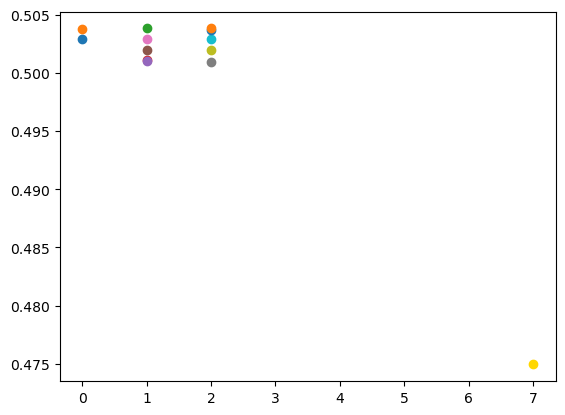

In [101]:
e = 2
tree = grow(5, 'low', e)
l = tree.sort_by_level()

for j in range(l.shape[0]):
    for i in range(l.shape[1]):
        if l[j][i] != 0:
            plt.scatter(j, l[j][i])

plt.scatter(e+5, dnn_model(goal), c='gold')
plt.show()

In [111]:
e = 20
binary_tree = grow(2, 'low', e)
c = binary_tree.sort_by_level()

for j in range(c.shape[0]):
    for i in range(c.shape[1]):
        if c[j][i] != 0:
            plt.scatter(j, c[j][i])

plt.scatter(e+5, dnn_model(goal), c='gold')
plt.show()

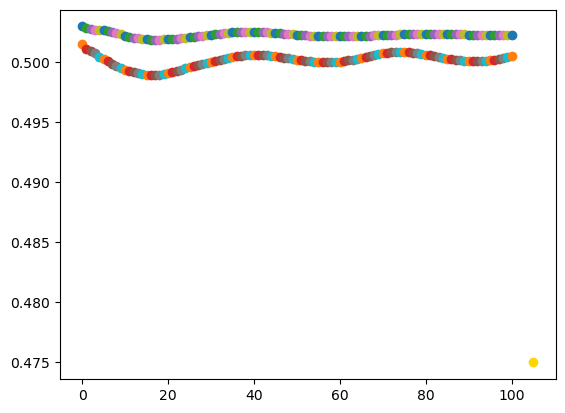

In [110]:
e = 100
mean_tree = grow(1, 'mean', e)
d = mean_tree.sort_by_level()

low_tree = grow(1, 'low', e)
b = low_tree.sort_by_level()

for j in range(d.shape[0]):
    for i in range(d.shape[1]):
        if d[j][i] != 0:
            plt.scatter(j, d[j][i])

        if b[j][i] != 0:
            plt.scatter(j, b[j][i])

plt.scatter(e+5, dnn_model(goal), c='gold')
plt.show()